# Telco Customer Churn

### What is churn?
Customers who have stopped using our services within a period of time.

## Goals:


* Find features that impact customer churn
* Develop a model that can accurately predict the likelihood a customer will churn or not.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from scipy import stats
import acquire
import prepare

## Acquire
   * Data acquired from Codeup database.
   * 24 columns and 7043 rows before cleaning.
   * Each row is a customer with the telco company.
   * Each column contains information about the customer and their services with telco.

## Prepare
   * Removed any duplicate rows from the dataset.
   * Dropped columns that had no useful information
   * Cleaned the total charges column and converted values to floats.
   * Filled null values in total charges with median value of column.
       * Median was used due to outliers skewing the mean.
   * Encoded categorical data.
   * Split the data into train, validate, split in a 50, 30, 20 split, stratified on churn.

## Data Dictionary

|**Feature**|**Description**|
|:-----------|:---------------|
|Gender  | Male or Female|
|Senior Citizen| Whether a customer is a senior citizen or not.|
|Partner| Whether a customer has a partner.|
|Dependents| Whether a customer has dependents.|
|Tenure| Length of time customer has been with Telco, measured in months.|
|Monthly Charges| Amount paid each month by customer.|
|Total Charges| Total amount paid by customer over tenure.|
|Churn (Target)| Yes or No, if a customer has churned or not.|
|Contract Type| The different lengths of contracts our customers have signed; month to month, one year, and two year.|
|Internet Service Types| Types of internet service that our customers use; DSL, Fiber Optics, and None.|

In [2]:
# acquire the data
telco = acquire.get_telco_data()

# clean the data
telco_clean = prepare.prep_telco(telco)

#split the data
train, validate, test = prepare.split_data(telco_clean, 'churn')

# Explore

   * Is contract type related to churn?
   * Is internet service type related to churn?
   * Are monthly charges related to churn?
   * Are total charges related to churn?
   * Is tenure related to churn?

### How often do customers churn?

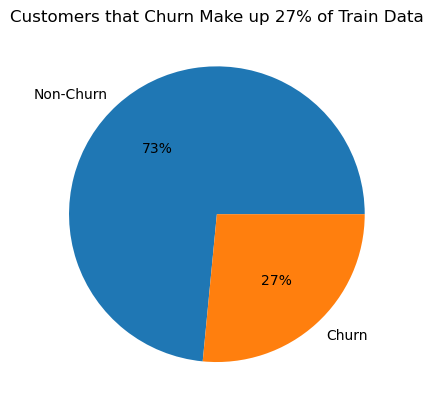

In [3]:
# visualize customer churn
labels = ['Non-Churn', 'Churn']
plt.pie(train.churn.value_counts(), labels=labels, autopct='%.0f%%')
plt.title("Customers that Churn Make up 27% of Train Data")
plt.show()

* Approximately 27% of customers will churn.

### Does contract type impact churn?

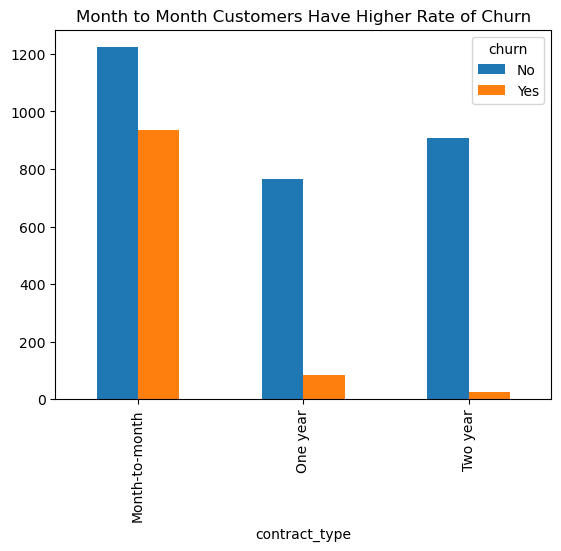

In [4]:
# create a crosstab between contract type and churn

contract_crosstab = pd.crosstab(index=train['contract_type'], columns=train['churn'])

# visualize contract_type and churn

contract_crosstab.plot.bar()
plt.title("Month to Month Customers Have Higher Rate of Churn")
plt.show()

* Visually, there is a significant difference in churn for customers with month-to-month contracts.


**I will use a $\chi^2$ test to see if there is statistical significance.**

* I will use a confidence interval of 95% and an alpha of .05


**$H_0$: Contract type and churn are independent of one another.**<br>
**$H_A$: Contract type and churn are related.**

In [5]:
# get p score
chi2, p, degf, expected = stats.chi2_contingency(contract_crosstab)

print(f'p = {p}')

p = 6.90388763811534e-154


**The p-value is less than the alpha. Therefore, we reject the null hypothesis and continue with the understanding that there is a relationship between contract type and churn.**

### Does internet service type impact churn?

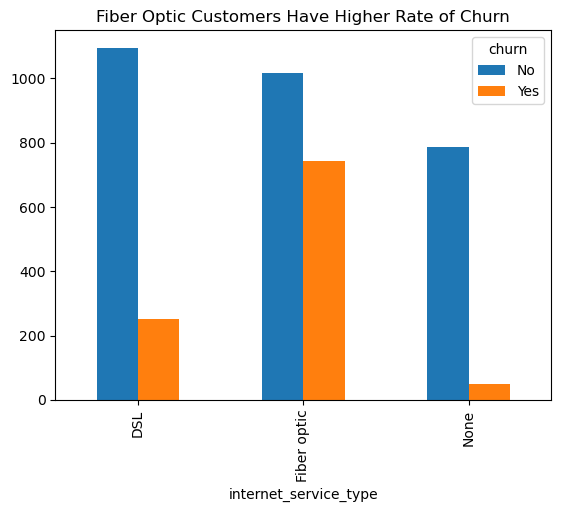

In [6]:
# create a crosstab of service type and churn

internet_crosstab = pd.crosstab(index=train['internet_service_type'], columns=train['churn'])

# visualize internet_service_type and churn

internet_crosstab.plot.bar()
plt.title("Fiber Optic Customers Have Higher Rate of Churn")
plt.show()

* Fiber optic customers have higher instances of churn than customers with DSL or no internet services.

**I will use a $\chi^2$ test to see if there is statistical significance.**

* I will use a confidence interval of 95% and an alpha of .05


**$H_0$: Internet service type and churn are independent of one another.**<br>
**$H_A$: Internet servive type and churn are related.**

In [7]:
# get p score
chi2, p, degf, expected = stats.chi2_contingency(internet_crosstab)

print(f'p = {p}')

p = 7.815797681295793e-98


**The p-value is less than the alpha. Therefore, we reject the null hypothesis and continue with the understanding that there is a relationship between internet service type and churn.**

### Do monthly charges impact churn?

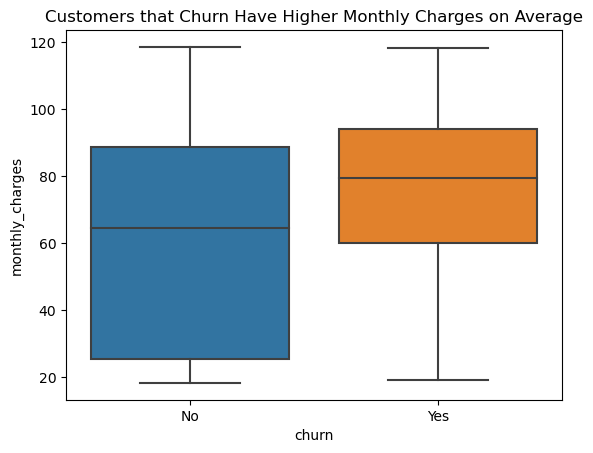

In [8]:
# visualize monthy_charges and churn
sns.boxplot(data=train, y='monthly_charges', x='churn')
plt.title("Customers that Churn Have Higher Monthly Charges on Average")
plt.show()

* Customers that churn have a higher monthly cost on average.

**I will use a Mann-Whitney u-test to determine any statistical significance.**
* There is not a normal distribution.
* The variances are not equal.
* I will use a confidence interval of 95% and an alpha of .05.

**$H_0$: Monthly charges of churn customers are lower than or equal to monthly charges of customers who do not churn.**<br>
**$H_A$: Monthly charges of churn customers are greater than monthly charges of customers who do not churn.**

In [9]:
# separate churn and non churn customer data
churn = train[train.churn =='Yes']
no_churn = train[train.churn == 'No']

# mann-whitney test for monthly charges
t, p = stats.mannwhitneyu(churn.monthly_charges, no_churn.monthly_charges, alternative="greater")

print(f'p = {p}')

p = 2.5550310599436916e-32


**The p-value is less than the alpha. Therefore, we reject the null hypothesis and continue with the understanding that customers who churn pay more in monthly charges than customers that do not churn.**

### Does tenure have an impact on churn?

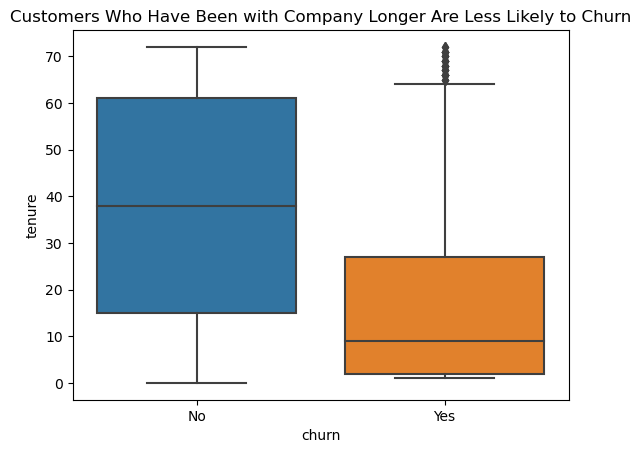

In [10]:
# visualize tenure vs churn

sns.boxplot(data=train, x="churn", y="tenure")
plt.title("Customers Who Have Been with Company Longer Are Less Likely to Churn")
plt.show()

* It appears that customers with longer tenure are less likely to churn.

**I will use a Mann-Whitney u-test to determine any statistical significance.**
* There is not a normal distribution.
* The variances are not equal.
* I will use a confidence interval of 95% and an alpha of .05.

**$H_0$: Tenure of churn customers is greater than or equal to tenure of customers who do not churn.**<br>
**$H_A$: Tenure of churn customers is less than tenure of customers who do not churn.**

In [11]:
# mann-whitney for tenure

t, p = stats.mannwhitneyu(churn.tenure, no_churn.tenure, alternative='less')

print(f'p = {p}')

p = 3.0717692013909187e-130


**The p-value is less than the alpha. Therefore, we reject the null hypothesis and continue with the understanding that customers who churn have shorter tenure than customers that do not churn.**

## Exploration Summary

* Contract type does have an impact on churn.<br>
    * *Month to month customers have a significantly higher rate of churn.*<br>
    
* Internet Service Type does have an impact on churn.<br>
    * *Fiber optics customers specifically have higher churn.*<br>
    
* Monthly charges do have an impact on churn. <br>

* Total charges does not have an impact on churn <br>
    * *Large number of outliers may have an impact on results.* <br>
    
* Tenure does have an impact on churn.
    * *There is statistical significance, though also a number of outliers for churn customers.*<br>

#### Features I will proceed with for model
* Contract Type, Internet Service Type, Monthly Charges, and Tenure


#### Features I will not proceed with for model
* Total charges

# Modeling

* I will use accuracy as my evaluation metric.
* No churn makes up 74% of data.

I will use the baseline of 74%, since guessing not churn for every customer would result in 74% accuracy.<br>
I will use four different models types.

In [13]:
# drop columns that won't be used in model

use_cols = ['churn_Yes', 'contract_type_One_year',
           'contract_type_Two_year',
           'tenure',
           'monthly_charges',
           'internet_service_type_Fiber_optic',
           'internet_service_type_None',]

train = train[use_cols]
validate = validate[use_cols]
test = test[use_cols]

# make model variables

X_train = train.drop(columns='churn_Yes')
y_train = train.churn_Yes

X_val = validate.drop(columns='churn_Yes')
y_val = validate.churn_Yes

X_test = test.drop(columns='churn_Yes')
y_test = test.churn_Yes

### Decision Tree

In [14]:
# create model
clf = DecisionTreeClassifier(max_depth=3, random_state=311)

# fit the model
clf = clf.fit(X_train, y_train)

In [15]:
# accuracy on train data
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

#accuracy on validate data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(clf.score(X_val, y_val)))

Accuracy of Decision Tree classifier on training set: 0.80
Accuracy of Decision Tree classifier on validate set: 0.77


* Accuracy for Decision Tree is better than baseline on train and slightly better than baseline on validate.

### Random Forest

In [16]:
# create the model
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=311)

# fit the model
rf = rf.fit(X_train, y_train)

In [17]:
# accuracy for train data
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

# accuracy for validate data
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_val, y_val)))

Accuracy of random forest classifier on training set: 0.80
Accuracy of random forest classifier on validate set: 0.78


* Accuracy for Random Forest is better than baseline on train and slightly better than baseline on validate.

### KNN

In [19]:
# create model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# fit the model
knn = knn.fit(X_train, y_train)

In [20]:
# accuracy for training data
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

#accuracy for validate data
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_val, y_val)))

Accuracy of KNN classifier on training set: 0.84
Accuracy of KNN classifier on validate set: 0.75


* Accuracy for KNN is better than baseline on train and slightly better than baseline on validate.

### Logistic Regression

In [22]:
# create model
logit = LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=311)

# fit model
logit = logit.fit(X_train, y_train)

In [23]:
# accuracy of train data
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

# accuracy of validate data
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_val, y_val)))

Accuracy of Logistic Regression classifier on training set: 0.33
Accuracy of Logistic Regression classifier on validate set: 0.33


* Accuracy for Logistic Regression is worse than baseline for both training and validate data.

## Comparing Models
* Baseline is 74% accuracy.
* Decision Tree, Random Forest, and KNN all performed better on training sets, with only slightly better results on validate than baseline.
* Logistic Regression did not have good results and will not be used moving forward.
* The best performing model was Random Forest with 78% accuracy so I will use the test data on that model.

### Random Forest Model on Test

In [26]:
# accuracy of rf on test data
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.79



## Modeling
The final model, Random Forest, performed better than baseline on all data sets.
* Tenure was an important feature for this model.
* Additional features may increase the accuracy of this model.
* No changes were made to initial hyperparameters so further exploration may yield better results.


## Recommendations
* Incentivise customers to move from month to month contracts to longer ones.
* Reward loyal customers to possibly increase tenure.

## Next Steps
* Look into cleaning and encoding data by mapping 'Yes' and 'No' values as bool for ease of use.
* Explore multivariate feature relationships:
    * Do longer tenured pay more or less in monthly charges and what type of contracts do they hold?
    * Are month to month customers paying higher monthly charges on average?
* Create a column with the number of additional services per customer for use as a feature.